In [1]:
#INPUT_MODEL = "../dec6_2000_episodes_gpu1/trained_sequential_rnn_5mixtures_run1/weights-improvement-168--130.67.hdf5"
INPUT_MODEL = "../dec6_2000_episodes_gpu1/trained_sequential_rnn_5mixtures_run1/rnn_trained_model.h5"
NUM_MIXTURES = 5
SIGMA_TEMP = 0.01
RNN_TRAINING_DATA_FILE = "../dec6_models/rnn_training_data.npz"
DREAM_WARM_STEPS = 100
PI_TEMPERATURE = 1.0

import keras
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

#Importing the VAE and RNN.
import os
import sys
#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyze_rnn_predictions
%load_ext autoreload
%autoreload 2 #If we want to automatically load external modules as they are updated.
#To access gym
import sys
sys.path.append('/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages')
import os

Using TensorFlow backend.


/home/kaiolae/code/word_models_keras_test/WorldModels
/home/kaiolae/code/word_models_keras_test/WorldModels


In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [3]:
rnn_analyzer = analyze_rnn_predictions.RNNAnalyzer(INPUT_MODEL, NUM_MIXTURES, PI_TEMPERATURE) #TODO Note, I previously used temp=0.1 - Which Ha noted was so low that we got mode collapse.
       

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   416         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_2[0][0]                   
_______________________

In [4]:
import numpy as np
import os
import random
# load preprocessed data
training_data = np.load(RNN_TRAINING_DATA_FILE)
action_data = training_data['action']
observation_data = training_data['latent']
#1000 entries in each.
#Produces a random start sequence to seed the dreams
def get_random_starting_sequence(minimal_length=100):
    rand_seq_id = random.randint(0,len(observation_data))
    rand_seq = observation_data[rand_seq_id]
    while len(rand_seq) < minimal_length:        
        rand_seq_id = random.randint(0,len(observation_data))
        rand_seq = observation_data[rand_seq_id]
    return observation_data[rand_seq_id], action_data[rand_seq_id]

def calc_mixture_weights_and_events_dreaming(rnn_analyzer, dream_steps=100, random_actions=True):
    #Analyzing a single model
    WARM_UP_STEPS = 0#150
    obs_seq, action_seq = get_random_starting_sequence(WARM_UP_STEPS+1)

    mixture_weight_history = []
    z_history = []
    rnn_analyzer._reset()
    rnn_analyzer.warm_up_lstm_with_single_input(obs_seq[0], DREAM_WARM_STEPS)
    #rnn_analyzer.warm_up_lstm(action_seq, obs_seq)
    
    #TODO Copy this approach to the other notebooks.
    for i in range(dream_steps):
        current_action=0
        if random_actions:
            action = rnn_analyzer.generate_random_action()
        previous_z, mixture_weights = rnn_analyzer.predict_one_step(action, sigma_temp=SIGMA_TEMP)#0.01)
        z_history.append(previous_z)
        mixture_weight_history.append(mixture_weights)
    return np.array(mixture_weight_history), np.array(z_history)

def visualize_mixture_weights_and_events(weights_sequence, z_sequence, rnn_analyzer):
    plt.plot(weights_sequence)
    columns = 4
    counter = 0
    skip_image = 5
    decoded_images = rnn_analyzer.decode_with_vae(z_sequence)
    plot_counter = 0
    
    rows = (len(decoded_images)/float(skip_image))/float(columns)
    f, axarr = plt.subplots(int(rows),int(columns), figsize=(15,15))
    f.subplots_adjust(hspace=0.25,wspace=-0.5)
    row = -1
    col = 0
    for d in decoded_images:
        if counter%skip_image == 0:
            if plot_counter%columns == 0:
                print("Timestep: ", counter)
                row+=1
                col=0
                
            axarr[row,col].imshow(d)                
            axarr[row,col].set_title(str(counter), fontsize=20)
            axarr[row,col].axis('off')
            #plt.subplot((len(z_sequence)//skip_image)//columns + 1, columns, plot_counter+1)

            #plt.imshow(d)
            plot_counter+=1
            col+=1
        counter+=1
    #plt.tight_layout()


Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80


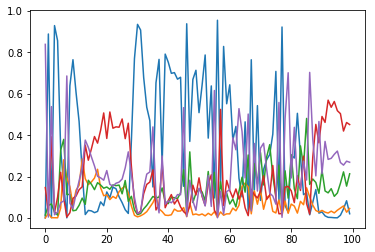

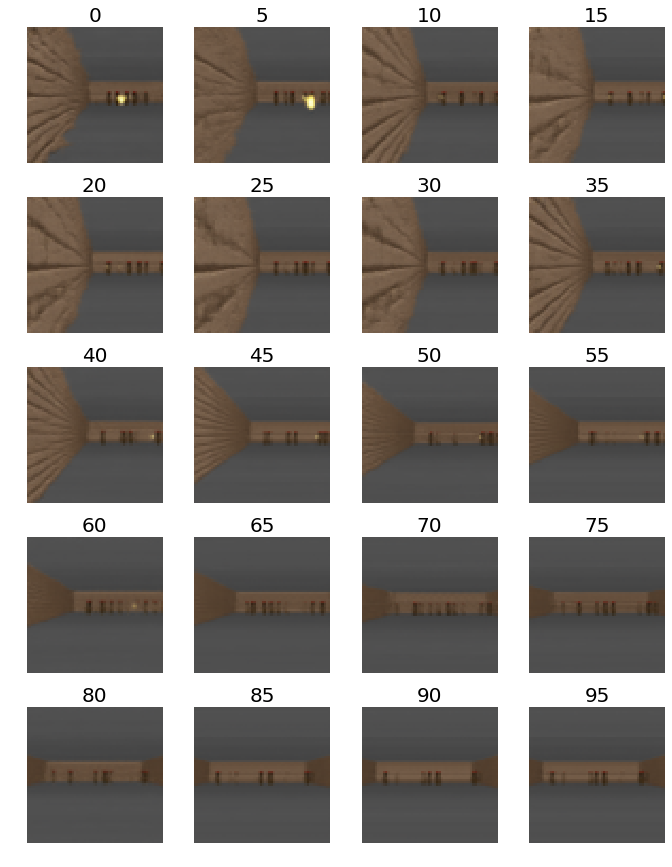

In [17]:
weights, zs = calc_mixture_weights_and_events_dreaming(rnn_analyzer)
visualize_mixture_weights_and_events(weights, zs, rnn_analyzer)